Student name: Diego Vallejos Salas

Student pace: self paced

Scheduled project review date/time: 06/21/2020

Instructor name: Jeff Herman

Blog post URL: https://diegovallejossalas.github.io/northwind_project

Importing libraries, we're adding them on the march.

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

Hi there, this is my second project for data science career at Flatiron school. For this project we were working with the Northwind database that contains information from a fictional company.

For this project we need to query a database to get the data and perform a statistical analysis. There we need to define a hypothesis, this includes to define a null and alternative hypothesis. Why?

When scientists do research and investigate about certain phenomena, they can’t assume deliberately i.e. that A causes B. They instead create a null hypothesis that states exactly the opposite they thing would happen. So the main point here is to reject that null hypothesis with a certain level of confidence.

In this project i'm going to try to respond the next questions:


1- Does discount amount have a statistically significant effect on the quantity of a product in an order? 

2- If so, at what level(s) of discount?

3- Is there a significant difference in profit when discounts are applied?

4- Is there a significant difference in profit between customer's countries?

5- Is there a significant difference in quantity of orders per month?


#### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

So we need to define our hypothesis as:

### H0 = There is no significant difference in quantity of products in orders when discounts are applied.

### H1 = There is a significant difference in quantity of products in orders when discounts are applied.


In this case we are going to use a one-tail test because we are expecting a possitive difference and set out alpha on 0.05

Let's connect with the tables and get the info in a dataframe.

In this case we're joining info from Product and Orderdetail tables. So far, they have all the data we need to make our first task.

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
#The selected table is OrderDetail because the discount info is there.
cur.execute("""SELECT OrderID, ProductID, ProductName, CategoryID, 
               UnitPrice, Quantity, Discount
               FROM Product
               JOIN OrderDetail
               USING(UnitPrice)""")
# Let's put the info in a df.
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df.head()

,OrderId,ProductId,ProductName,CategoryId,UnitPrice,Quantity,Discount
0,10508,39,Chai,1,18.0,10,0.00
1,10521,35,Chai,1,18.0,3,0.00
2,10522,1,Chai,1,18.0,40,0.20
3,10526,1,Chai,1,18.0,8,0.15
4,10530,76,Chai,1,18.0,50,0.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458 entries, 0 to 2457
Data columns (total 7 columns):
OrderId        2458 non-null int64
ProductId      2458 non-null int64
ProductName    2458 non-null object
CategoryId     2458 non-null int64
UnitPrice      2458 non-null float64
Quantity       2458 non-null int64
Discount       2458 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 134.5+ KB


As we can se above, the dataframe has no null or missing values.

In [4]:
df.Discount.value_counts()

0.00    1497
0.05     209
0.20     198
0.25     191
0.15     184
0.10     170
0.03       3
0.01       2
0.02       2
0.04       1
0.06       1
Name: Discount, dtype: int64

Let's divide the dataset into 2 different parts in order to create control and experimental groups. 

Control group is no discount sells

Experimental group is discounted sells

We're using the mean of quantities to get the welch's t-test

In [5]:
experimental = df[df['Discount'] != 0].groupby('ProductId')['Quantity'].mean()
print(experimental.head())
print(experimental.shape)

ProductId
1    27.846154
2    24.294118
3    20.000000
4    30.875000
5    30.500000
Name: Quantity, dtype: float64
(75,)


In [6]:
control = df[df['Discount'] == 0].groupby('ProductId')['Quantity'].mean()
print(control.head())
print(control.shape)

ProductId
1    18.250000
2    17.357143
3    26.000000
4    13.833333
5    29.333333
Name: Quantity, dtype: float64
(77,)


Now let's see if the geoups have a normal distribution

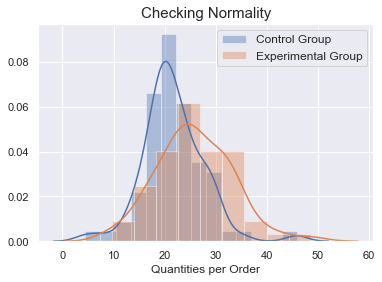

In [7]:
sns.set(color_codes=True)
sns.distplot(control, label='Control Group')
sns.distplot(experimental, label='Experimental Group',kde=True, hist=True)

plt.title('Checking Normality', fontsize=15)
plt.xlabel('Quantities per Order', fontsize=12)
plt.legend(fontsize=12);

In [8]:
print(stats.normaltest(experimental))
print(stats.normaltest(control))

NormaltestResult(statistic=2.3335048287489526, pvalue=0.31137652294673224)
NormaltestResult(statistic=15.16112457416758, pvalue=0.0005102742217293562)


As we can see, the experimental group doesn't have a normal distribution.

Let's compare means

In [9]:
mean_e, std_e = experimental.mean(), experimental.std()
print(mean_e, std_e)
mean_c, std_c = control.mean(), control.std()
print(mean_c, std_c)

25.807088859515478 7.347879240868641
21.705993133482295 5.970687398995659


In [10]:
difference_in_means = abs(experimental.mean() - control.mean())
difference_in_means

4.101095726033183

In this case we're going to apply cohen's d to measure the size effect and see how different they are.

In [11]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [12]:
Cohen_d(experimental,control)

0.6134064659983942

The result shows us that we have a medium effect size.



Let's define some functions in order to get out p-value

Welch's t test 

welch's degrees of freedom

P-Value

When sizes and sample variances between the two groups are not equal, Welch's t-test is generally a more reliable test.

In [13]:
def welch_t(a, b):

    numerator = a.mean() - b.mean()
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

In [14]:
def welch_df(a, b):

    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

In [15]:
t = welch_t(experimental, control)
dfr = welch_df(experimental, control)
print(t,dfr)

3.7707979879779603 142.42959979066148


In [16]:
p = 1 - stats.t.cdf(t, dfr)
print('Our P-Value is ',p)

Our P-Value is  0.00011889999780123617


### Excelent, our P-value is less than our alpha 0.05 so we can reject the null hypothesis and assume that the discounts increases the quantity of products in orders.

what levels of discounts make a difference in quantity of orders?

### Question # 2

Assuming that the H0 was rejected:

## Wich level of discount has a mayor impact in orders quantity?

In this case out hypothesis are:

#### H0: There is no significant difference in effect of different discounts over quantities of products ordered.

#### H1: There is a significant difference in effect of different discounts over quantities of products ordered.

In [17]:
df['Discount'].value_counts()

0.00    1497
0.05     209
0.20     198
0.25     191
0.15     184
0.10     170
0.03       3
0.01       2
0.02       2
0.04       1
0.06       1
Name: Discount, dtype: int64

As we've seen before, we have basically 5 type of discounts, so let's create a new dataframe without 0.1, 0.2 , 0.3, 0.4 and 0.6 discount categories.

In [18]:
dfd = df[df.Discount.isin([0.00, 0.05, 0.10, 0.15, 0.20, 0.25])] 
dfd.head()

,OrderId,ProductId,ProductName,CategoryId,UnitPrice,Quantity,Discount
0,10508,39,Chai,1,18.0,10,0.00
1,10521,35,Chai,1,18.0,3,0.00
2,10522,1,Chai,1,18.0,40,0.20
3,10526,1,Chai,1,18.0,8,0.15
4,10530,76,Chai,1,18.0,50,0.00


In [19]:
dfd.shape

(2449, 7)

Now, let's plot the differents level of discount by mean and no discount too just in order to compare and confirm differences.

Text(0.5, 1.0, 'Avg quantity per Discount')

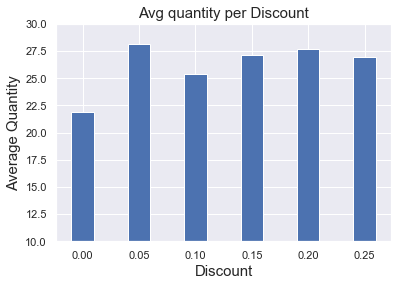

In [43]:
X = []
y = []
for i in dfd['Discount'].unique():
    X.append(i)
    y.append(dfd['Quantity'][dfd['Discount'] == i].mean())
ax = plt.bar(X,y,width=.02)
plt.ylim(10,30)
plt.ylabel('Average Quantity',fontsize = 15)
plt.xlabel('Discount',fontsize = 15)
plt.title('Avg quantity per Discount', fontsize = 15)

As we can see there is a small difference but anyways we have to assure that this result is not due to randomness so in this case it would be appropiate to use ANOVA test to compare different groups.

In [21]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, dfd).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),5.0,16903.249542,3380.649908,9.071374,1.472424e-08
Residual,2443.0,910438.406644,372.672291,NaN,NaN


### Our P-value is equal to 1.4724 so we can not reject the H0 wich states that there is no significant difference in orders quantity between different discounts.

### Question 3

### Is there a significant difference in profit when discounts are applied?

#### H0 = There is no significant difference in Profit in orders when discounts are applied.

#### H1 = There is a significant difference in profit in orders when discounts are applied.

In [22]:
cur.execute("""SELECT OrderID, ProductID, ProductName, CategoryID, 
               UnitPrice, Quantity, Discount, UnitPrice * Quantity AS Profit
               FROM Product
               JOIN OrderDetail
               USING(UnitPrice)""")
# Let's put the info in a df.
dfp = pd.DataFrame(cur.fetchall())
dfp.columns = [i[0] for i in cur.description]
dfp.head()

,OrderId,ProductId,ProductName,CategoryId,UnitPrice,Quantity,Discount,Profit
0,10508,39,Chai,1,18.0,10,0.00,180.0
1,10521,35,Chai,1,18.0,3,0.00,54.0
2,10522,1,Chai,1,18.0,40,0.20,720.0
3,10526,1,Chai,1,18.0,8,0.15,144.0
4,10530,76,Chai,1,18.0,50,0.00,900.0


We need to perform some operations to add some info in the df.

In [23]:
dfp['DiscountAmount']= abs((dfp['UnitPrice']*dfp['Quantity']) * dfp['Discount'])
dfp['TotalProfit']= dfp['Profit'] - dfp['DiscountAmount']
dfp.head()

,OrderId,ProductId,ProductName,CategoryId,UnitPrice,Quantity,Discount,Profit,DiscountAmount,TotalProfit
0,10508,39,Chai,1,18.0,10,0.00,180.0,0.0,180.0
1,10521,35,Chai,1,18.0,3,0.00,54.0,0.0,54.0
2,10522,1,Chai,1,18.0,40,0.20,720.0,144.0,576.0
3,10526,1,Chai,1,18.0,8,0.15,144.0,21.6,122.4
4,10530,76,Chai,1,18.0,50,0.00,900.0,0.0,900.0


In [41]:
#Grouping discounted products and their profit.
dfp1 = dfp[dfp['Discount'] != 0].groupby('ProductId')['Profit'].mean()
print(dfp1.head())
print(dfp1.shape)

ProductId
1    501.230769
2    461.588235
3    200.000000
4    679.250000
5    567.437500
Name: Profit, dtype: float64
(75,)


In [42]:
#Grouping discounted products and their profit with discount subtracted.
dfp2 = dfp[dfp['Discount'] != 0].groupby('ProductId')['TotalProfit'].mean()
print(dfp2.head())
print(dfp2.shape)

ProductId
1    401.607692
2    369.717647
3    180.000000
4    583.137500
5    453.950000
Name: TotalProfit, dtype: float64
(75,)


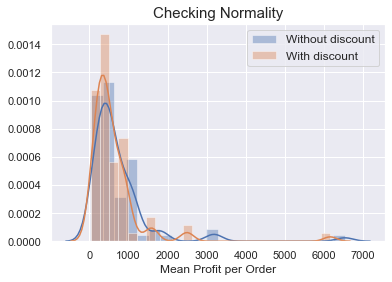

In [26]:
sns.set(color_codes=True)
sns.distplot(dfp1, label='Without discount')
sns.distplot(dfp2, label='With discount',kde=True, hist=True)

plt.title('Checking Normality', fontsize=15)
plt.xlabel('Mean Profit per Order', fontsize=12)
plt.legend(fontsize=12);

In [27]:
stats.ttest_ind(dfp1, dfp2)

Ttest_indResult(statistic=0.7734188190551307, pvalue=0.440508122481454)

In [28]:
print(stats.normaltest(dfp1))
print(stats.normaltest(dfp2))

NormaltestResult(statistic=102.97709082480642, pvalue=4.35320226201066e-23)
NormaltestResult(statistic=113.1252310032559, pvalue=2.7237560356909527e-25)


In [29]:
mean_1, std_1 = dfp1.mean(), dfp1.std()
print(mean_1, std_1)
mean_2, std_2 = dfp2.mean(), dfp2.std()
print(mean_2, std_2)

741.7413276293828 889.5105085662593
634.9739083097364 798.7644329192968


In [30]:
difference_in_means = abs(dfp1.mean() - dfp2.mean())
difference_in_means

106.76741931964636

In [31]:
Cohen_d(dfp1,dfp2)

0.12629876427673462

The result shows us that we have a low size effect.

In [32]:
t2 = welch_t(dfp1, dfp2)
dfr2 = welch_df(dfp1, dfp2)
print(t2,dfr2)

0.7734188190551299 146.318783787519


In [33]:
p2 = 1 - stats.t.cdf(t2, dfr2)
print('Our P-Value is ',p2)

Our P-Value is  0.22026113814995663


#### We can not reject our null hypothesis, said this, we can assume that there is no statistical significance in the money we're not incoming due to discounts.

### Question 4

### Is there a significant difference in profit between customer’s region?


#### H0: there is no significant difference in profit mean of products purchased by region

#### H1: there is a significant difference in profit mean of products purchased by region

In [34]:
cur.execute("""SELECT c.Region, od.Quantity, od.UnitPrice, od.Discount, od.Quantity*od.UnitPrice AS Profit
            FROM Customer c
            JOIN [Order] o ON c.Id = o.CustomerId
            JOIN OrderDetail od ON od.OrderId = o.Id""")
dfc2 = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
dfc2.columns = [i[0] for i in cur.description]
dfc2.head(10)

,Region,Quantity,UnitPrice,Discount,Profit
0,Western Europe,12,14.0,0.00,168.0
1,Western Europe,10,9.8,0.00,98.0
2,Western Europe,5,34.8,0.00,174.0
3,Western Europe,9,18.6,0.00,167.4
4,Western Europe,40,42.4,0.00,1696.0
5,South America,10,7.7,0.00,77.0
6,South America,35,42.4,0.15,1484.0
7,South America,15,16.8,0.15,252.0
8,Western Europe,6,16.8,0.05,100.8
9,Western Europe,15,15.6,0.05,234.0


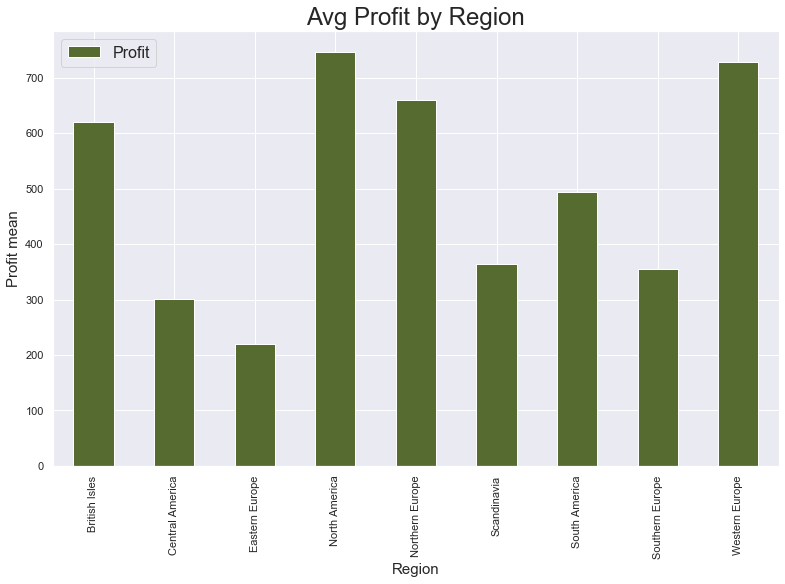

In [35]:
new_figure = plt.figure(figsize=(13,8))
dfc2.groupby("Region")["Profit"].mean().plot(kind="bar", color = 'darkolivegreen')
plt.title('Avg Profit by Region', fontsize = 24)
plt.legend(fontsize = 16)
plt.xlabel('Region', fontsize = 15)
plt.ylabel('Profit mean', fontsize = 15);

In [36]:
formula = 'Profit ~ C(Region)'
lm = ols(formula, dfc2).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Region),8.0,4.264262e+07,5.330327e+06,5.030355,0.000003
Residual,2069.0,2.192379e+09,1.059632e+06,NaN,NaN


#### We can reject the null hypothesis and say that the mean profit is considerable different between regions.

### Question 5

Let's see if there is a difference between months in quantity of orders

#### H0: there is no significant difference in quantity of products purchased by month

#### H1: there is a significant difference in quantity of products purchased by month

In [37]:
cur.execute("""SELECT o.OrderDate, od.Quantity 
               FROM [Order] o 
               JOIN OrderDetail od 
               ON od.OrderID=o.ID""")
q5 = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
q5.columns = [i[0] for i in cur.description]
print(q5.shape)
q5.head()

(2155, 2)


,OrderDate,Quantity
0,2012-07-04,12
1,2012-07-04,10
2,2012-07-04,5
3,2012-07-05,9
4,2012-07-05,40


In [38]:
q5["OrderDate"]=pd.to_datetime(q5["OrderDate"])
q5["Month"] = q5["OrderDate"].dt.month
q5.head()

,OrderDate,Quantity,Month
0,2012-07-04,12,7
1,2012-07-04,10,7
2,2012-07-04,5,7
3,2012-07-05,9,7
4,2012-07-05,40,7


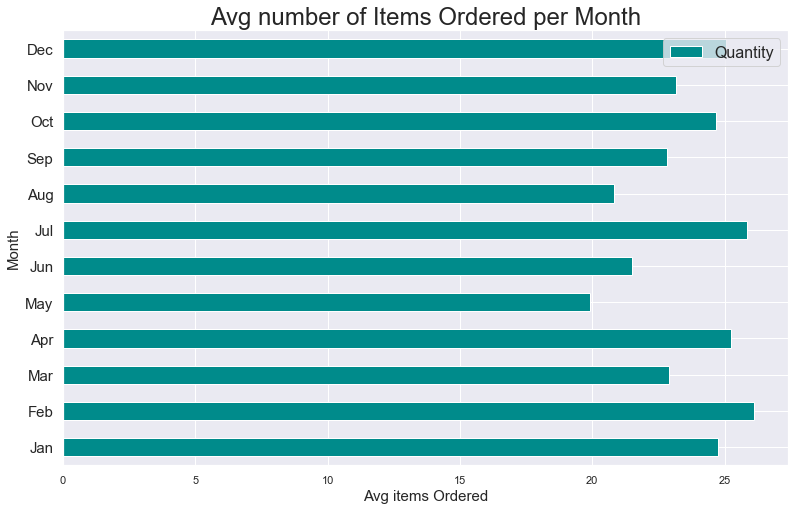

In [39]:
new_figure = plt.figure(figsize=(13,8))
q5g = q5.groupby(["Month"])["Quantity"].mean().plot(kind="barh", color= 'darkcyan')
q5g.set_title("Avg number of Items Ordered per Month", fontsize = 24)
plt.legend(fontsize = 16)
q5g.set_xlabel("Avg items Ordered", fontsize = 15)
q5g.set_ylabel("Month", fontsize = 15)
plt.yticks(range(0,12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 15);

In [40]:
formula = 'Quantity ~ C(Month)'
lm = ols(formula, q5).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Month),11.0,7395.980026,672.361821,1.866405,0.039229
Residual,2143.0,772003.656168,360.244357,NaN,NaN


We can reject the null hypothesis and assume that the profit is considerable different between months.

### Conclusions

1-  When the company applies discounts the quantity of products per order will increase.

2-  The quantity of products per order won't increase due to the amount of discount. This means that applying a 5% or 25% the    company will increase the number of products per order in a very similar amount. Due to this, we suggest to decision makers to try to apply just 5% of discount and maybe use that 25% in some specific kind of products or customers.

3-  We can assume that the profit of the company is not significantly affected when discounts are applied to products.

4-  We can assume that the mean profit is significantly different between regions. Said that, we can try to increase or sales force in those regions where the mean profit is higher that others. At the same time we can apply agressive discounts to regions with lower profit per order so the company can penetrate the market.

5-  We could see that the quantity of products vary significantly between months, so this is telling us when should we apply discounts or vary the amount of them.

### Suggestions for the company

It would be very useful to have the total profit of each product with the logistics and workforce discounted. In that way we can have a better idea of which products are being more important to the company in order to make profits.

Get deeper into people, shipping and time for delivery.

Is there a discount limit that we can give without affecting profits?
